In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy,tqdm # CUDA interface for python
%load_ext autoreload
%autoreload 2
%load_ext autotime

# add parent path to PATH
import sys
sys.path.append('..')

time: 482 µs (started: 2023-03-14 12:00:45 +02:00)


In [2]:
import fastqslpy

TraceAllBline = fastqslpy.kernels.compileTraceBlineAdaptive()

compiling kernel
/proj/peijinzh/fastqsl/FastQSL/fastqslpy
/proj/peijinzh/fastqsl/FastQSL/fastqslpy/kernels.py
/proj/peijinzh/fastqsl/FastQSL/fastqslpy/cu
time: 1.03 s (started: 2023-03-14 12:00:46 +02:00)


In [3]:
a = sciIO.readsav('../data/TD7.sav')
print(a.keys())

dict_keys(['bx', 'by', 'bz', 'xreg_kt', 'yreg_kt', 'zreg_kt', 'resolution'])
time: 495 ms (started: 2023-03-14 12:00:47 +02:00)


In [4]:
# need to be transposed because of the storage toplogy of fortran and python
Bx = np.transpose(a.bx,(2,1,0)).astype(np.float32)
By = np.transpose(a.by,(2,1,0)).astype(np.float32)
Bz = np.transpose(a.bz,(2,1,0)).astype(np.float32)
(Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False
#plt.imshow(Bz[:,:,50].T) 

time: 464 ms (started: 2023-03-14 12:00:50 +02:00)


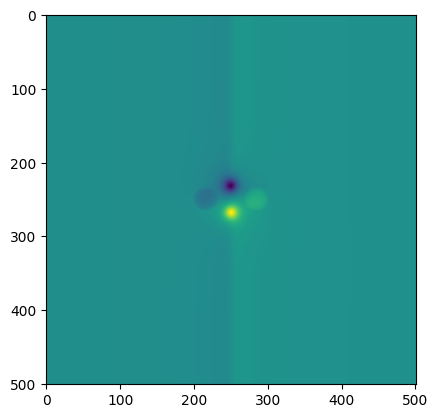

time: 225 ms (started: 2023-03-14 12:00:52 +02:00)


In [5]:
plt.imshow(Bz[:,:,0])

In [6]:
#import os
#print('compiling kernel')
#PWD = os.getcwd()
#traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
#TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
#TraceAllBline = TraceFunc.get_function("TraceAllBline")

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)

dummy=cupy.zeros([1,1],dtype=cupy.float32)
dummy64=cupy.zeros([1,1],dtype=cupy.float64)
flag_twist=cupy.array([True],dtype=cupy.bool_)
flag_twist_false=cupy.array([False],dtype=cupy.bool_)

transfering B-field to GPU
time: 650 ms (started: 2023-03-14 12:00:52 +02:00)


In [7]:
xfull =np.arange(Bx.shape[0])
yfull =np.arange(Bx.shape[1])
zfull =np.arange(Bx.shape[2])
Bx_gpu.shape

(501, 501, 501)

time: 1.44 ms (started: 2023-03-14 12:00:53 +02:00)


In [8]:
# calc curl(B)
curBx_gpu = cupy.zeros_like(Bx_gpu)
curBy_gpu = cupy.zeros_like(By_gpu)
curBz_gpu = cupy.zeros_like(Bz_gpu)

curBx_gpu[:,1:-1,1:-1] = ((Bz_gpu[:,2:,  1:-1]-Bz_gpu[:,0:-2,1:-1])/2.
                         -(By_gpu[:,1:-1,2:]-  By_gpu[:,1:-1,0:-2])/2)
curBy_gpu[1:-1,:,1:-1] = ((Bx_gpu[1:-1,:,2:]-  Bx_gpu[1:-1,:,0:-2])/2.
                         -(Bz_gpu[2:,  :,1:-1]-Bz_gpu[0:-2,:,1:-1])/2)
curBz_gpu[1:-1,1:-1,:] = ((By_gpu[2:,  1:-1,:]-By_gpu[0:-2,1:-1,:])/2.
                         -(Bx_gpu[1:-1,2:,  :]-Bx_gpu[1:-1,0:-2,:])/2)

# take care of z=0
curBx_gpu[1:-1,1:-1,0] = ((Bz_gpu[1:-1,2:,  0]-Bz_gpu[1:-1,0:-2,0])/2.
                         -(-3.*By_gpu[1:-1,1:-1,0]+4.*By_gpu[1:-1,1:-1,1]-By_gpu[1:-1,1:-1,2])/2)
curBy_gpu[1:-1,1:-1,0] = ((-3.*Bx_gpu[1:-1,1:-1,0]+4.*Bx_gpu[1:-1,1:-1,1]-Bx_gpu[1:-1,1:-1,2])/2.
                         -(Bz_gpu[2:,  1:-1,0]-Bz_gpu[0:-2,1:-1,0])/2)

time: 544 ms (started: 2023-03-14 12:00:54 +02:00)


(200.0, 300.0)

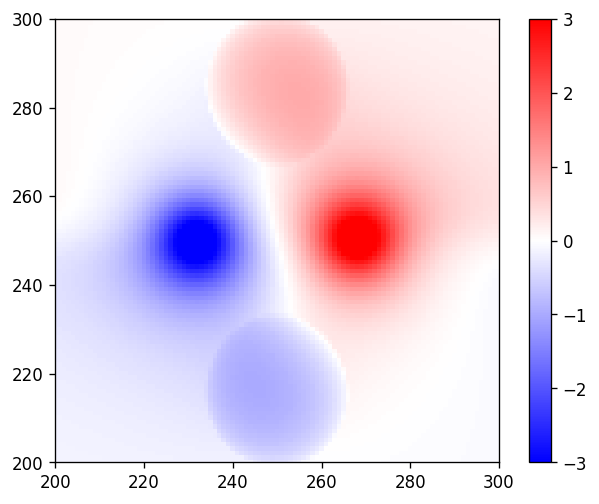

time: 179 ms (started: 2023-03-14 12:00:54 +02:00)


In [9]:
plt.figure(dpi=120)
plt.imshow(Bz_gpu[:,:,0].get().T,origin='lower',vmax=3,vmin=-3,cmap='bwr')
plt.colorbar()
plt.xlim([200,300])
plt.ylim([200,300])

In [10]:
import FastQSL
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
print(BshapeN)
BshapeN = cupy.array(BshapeN)

interp_ratio=6
stride_step=1/interp_ratio
x_range = [0,1163]
y_range = [0,487]
#x_range = [220,280]
y_range = [190,310]
x_range = [220,280]

#y_range = [50,250]
#x_range = [250,450]
z_range = [0,60]
#z_range = [0,1]

x_i = cupy.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=cupy.float32)
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)
z_i = cupy.linspace(*z_range, np.uint(interp_ratio*(z_range[1]-z_range[0])),dtype=cupy.float32)

x_arr,y_arr = cupy.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten()
y_inp = y_arr.flatten()

#z_inp[:] = +23.583333

if not flag_init:
    (x_start,y_start,z_start, x_end,y_end,z_end,
     Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    flag_init=True

line_len = cupy.zeros(x_inp.shape,cupy.float64)
N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
s_len    = cupy.array([1./16.],cupy.float32)
tol_coef    = cupy.array([cupy.sqrt(1)],cupy.float32)


inp_norm = cupy.array([0,0,1.],cupy.float32)

twist_all = cupy.zeros(x_inp.shape,cupy.float64)

# for GTX 1060
#blck=(64,1,1)
#grd = (20,1)

# for GTX1080ti,P100
blck=(128,1,1)
grd = (28,1)

cupy.cuda.stream.get_current_stream().synchronize()

[501 501 501]
time: 139 ms (started: 2023-03-14 12:00:55 +02:00)


In [11]:
Qube=np.zeros([xy_shape[1],xy_shape[0],z_i.shape[0]],dtype=np.float32)
Twube=np.zeros([xy_shape[1],xy_shape[0],z_i.shape[0]],dtype=np.float32)
Liube=np.zeros([xy_shape[1],xy_shape[0],z_i.shape[0]],dtype=np.float32)
#z_i=z_i*0+20

B0cube = np.zeros(x_arr.shape,dtype=np.float32)

time: 999 µs (started: 2023-03-14 12:00:56 +02:00)


In [12]:
Liube.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

time: 1.28 ms (started: 2023-03-14 12:00:57 +02:00)


In [13]:
pinned_mempool = cupy.get_default_pinned_memory_pool()
for idx_pos_z,z_pos in tqdm.tqdm(enumerate(z_i)):
    
    x_inp = x_arr.flatten()
    y_inp = y_arr.flatten()
    z_inp = (cupy.zeros_like(x_inp,cupy.float32)+z_pos)
    
    (x_start,y_start,z_start, x_end,y_end,z_end,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    
    cupy.cuda.stream.get_current_stream().synchronize()
    # run the big calclation
    TraceAllBline(blck,grd,
                (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
                curBx_gpu,curBy_gpu,curBz_gpu,twist_all,flag_twist,
                x_inp,   y_inp,   z_inp,inp_norm,
                x_start, y_start, z_start, flag_start,
                x_end,   y_end,   z_end,   flag_end,
                Bx_inp,  By_inp,  Bz_inp,  B_flag,
                Bx_start,By_start,Bz_start,
                Bx_end,  By_end,  Bz_end,  
                s_len,N,line_len, tol_coef))
    cupy.cuda.stream.get_current_stream().synchronize()
    (x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
     x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
     Bx_in_arr,   By_in_arr,  Bz_in_arr,
     Bx_out_arr,  By_out_arr, Bz_out_arr,
     Bx_0_arr,    By_0_arr,   Bz_0_arr,   B_flag_arr, twist_all_arr,
     line_len_arr) = FastQSL.ResReshape(xy_shape,
                    x_end,y_end,z_end,flag_end,
                    x_start,y_start,z_start,flag_start,
                    Bx_start,By_start,Bz_start,
                    Bx_end,By_end,Bz_end, 
                    Bx_inp,By_inp,Bz_inp,B_flag,twist_all,line_len)
    
    if z_pos<1e-5:
        B0cube=Bz_0_arr.get()
    
    cupy.cuda.stream.get_current_stream().synchronize()
    Q=FastQSL.QCalcPlane(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bx_0_arr,    By_0_arr,   Bz_0_arr,    
         B_flag_arr, stride_step)
    stride_this  =  cupy.float32(1./interp_ratio)/8

    (cut_inp_x,   cut_inp_y,   cut_inp_z,
        cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
        cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
        Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
        Bx_start_cut,By_start_cut,Bz_start_cut,
        Bx_end_cut,  By_end_cut,  Bz_end_cut,  
        N_cut,line_len_cut,Bz0_start, Bz0_end)=FastQSL.CookPseudoLine(
             x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
             x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
             Bx_in_arr,   By_in_arr,  Bz_in_arr,
             Bx_out_arr,  By_out_arr, Bz_out_arr,
             Bz_0_arr,    B_flag_arr, stride_this)
    
    cupy.cuda.stream.get_current_stream().synchronize()
    TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
              dummy,dummy,dummy,dummy64,flag_twist_false,
            cut_inp_x,   cut_inp_y,   cut_inp_z,inp_norm,
            cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
            cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
            Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
            Bx_start_cut,By_start_cut,Bz_start_cut,
            Bx_end_cut,  By_end_cut,  Bz_end_cut,  
            s_len,N_cut,line_len_cut, tol_coef*.1))
    
    
    cupy.cuda.stream.get_current_stream().synchronize()
    (X1,Y1,X2,Y2) = [cupy.zeros(cut_inp_x.shape,dtype=cupy.float32) 
                     for _ in range(4)];

    idx_Z1_cut=(flag_cut_start-1)//2 == 2;  idx_Z2_cut=(flag_cut_end-1)//2 == 2
    idx_Y1_cut=(flag_cut_start-1)//2 == 1;  idx_Y2_cut=(flag_cut_end-1)//2 == 1
    idx_X1_cut=(flag_cut_start-1)//2 == 0;  idx_X2_cut=(flag_cut_end-1)//2 == 0

    
    cupy.cuda.stream.get_current_stream().synchronize()
    # Z plane
    X1[idx_Z1_cut] = cut_start_x[idx_Z1_cut]; Y1[idx_Z1_cut] = cut_start_y[idx_Z1_cut] 
    X2[idx_Z2_cut] = cut_end_x[idx_Z2_cut];   Y2[idx_Z2_cut] = cut_end_y[idx_Z2_cut] 
    # Y plane
    X1[idx_Y1_cut] = cut_start_z[idx_Y1_cut]; Y1[idx_Y1_cut] = cut_start_x[idx_Y1_cut]
    X2[idx_Y2_cut] = cut_end_z[idx_Y2_cut];   Y2[idx_Y2_cut] = cut_end_x[idx_Y2_cut]
    # X plane
    X1[idx_X1_cut] = cut_start_y[idx_X1_cut]; Y1[idx_X1_cut] = cut_start_z[idx_X1_cut]
    X2[idx_X2_cut] = cut_end_y[idx_X2_cut];   Y2[idx_X2_cut] = cut_end_z[idx_X2_cut]

    dx2xc = X2[0::4]-X2[2::4]; dx2yc = X2[1::4]-X2[3::4];
    dy2xc = Y2[0::4]-Y2[2::4]; dy2yc = Y2[1::4]-Y2[3::4];
    dx1xc = X1[0::4]-X1[2::4]; dx1yc = X1[1::4]-X1[3::4];
    dy1xc = Y1[0::4]-Y1[2::4]; dy1yc = Y1[1::4]-Y1[3::4];
    a_cut = (dx2xc*dy1yc-dx2yc*dy1xc);
    b_cut = (dx2yc*dx1xc-dx2xc*dx1yc);
    c_cut = (dy2xc*dy1yc-dy2yc*dy1xc);
    d_cut = (dy2yc*dx1xc-dy2xc*dx1yc);

    bnr_cut = cupy.abs(Bz0_end)/(cupy.abs(Bz0_start))*((1/stride_this/2)**4)
    Qcut = (a_cut**2+b_cut**2+c_cut**2+d_cut**2)*bnr_cut
    Qcut[cupy.where(Qcut<1.0)]=1.0
    
    Q_all=cupy.zeros(x_end_arr.shape,dtype=cupy.float32)
    Q_all[1:-1,1:-1]=Q
    Q_all[B_flag_arr==1]=Qcut
    
    Qube[:,:,idx_pos_z]=Q_all.T.get()
    Twube[:,:,idx_pos_z]=twist_all_arr.T.get()
    Liube[:,:,idx_pos_z]=line_len_arr.T.get()
    
    cupy.cuda.stream.get_current_stream().synchronize()
    
    (x_start,y_start,z_start, x_end,y_end,z_end,z_inp,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[None for _ in range(16)]
    (B_flag,flag_start,flag_end)=[None for _ in range(3)]
    pinned_mempool.free_all_blocks()

360it [00:40,  8.97it/s]

time: 40.2 s (started: 2023-03-14 12:00:58 +02:00)


In [14]:
Qube.shape

(360, 720, 360)

time: 2.09 ms (started: 2023-03-14 12:02:12 +02:00)


In [15]:
#x_i_0 = np.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=np.float32)
#y_i_0 = np.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=np.float32)
#z_i_0 = np.linspace(*z_range, np.uint(interp_ratio*(z_range[1]-z_range[0])),dtype=np.float32)

r_pix=3.04

xi=x_i_0=(x_i.get()-Bx.shape[0]/2)*r_pix
yi=y_i_0=(y_i.get()-Bx.shape[0]/2)*r_pix
zi=z_i_0=(z_i.get())*r_pix

B0z=Bz[:,:,0]

x_arr_0,y_arr_0,z_arr_0 = np.meshgrid(x_i_0, y_i_0, z_i_0,indexing='ij')

time: 263 ms (started: 2023-03-14 12:02:14 +02:00)


In [16]:
x_arr_0.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

time: 1.46 ms (started: 2023-03-14 12:02:17 +02:00)


In [19]:
import k3d

twube_vol = k3d.volume(
    np.array(Twube))

plot = k3d.plot()
plot += twube_vol
plot.display()

Output()

time: 2.82 s (started: 2023-03-14 12:02:27 +02:00)


In [18]:
Qube.shape

(360, 720, 360)

time: 1.3 ms (started: 2023-03-14 12:02:19 +02:00)


In [20]:
import pyvista as pv
import MagTool as mt
p = pv.Plotter()

xx3,yy3,zz3 = np.meshgrid(xi, yi, zi,indexing='ij')
xx2,yy2 = np.meshgrid(xi, yi,indexing='ij')


grid = pv.StructuredGrid(xx3,yy3,zz3,indexing='ij')
grid["vol"] = Qube.T.flatten()
contours = grid.contour([500])
largest = contours.connectivity(largest=True)
surf = largest.extract_geometry()


time: 11.7 s


In [21]:
thetas  = np.linspace(0,0.5,120)

time: 0 ns


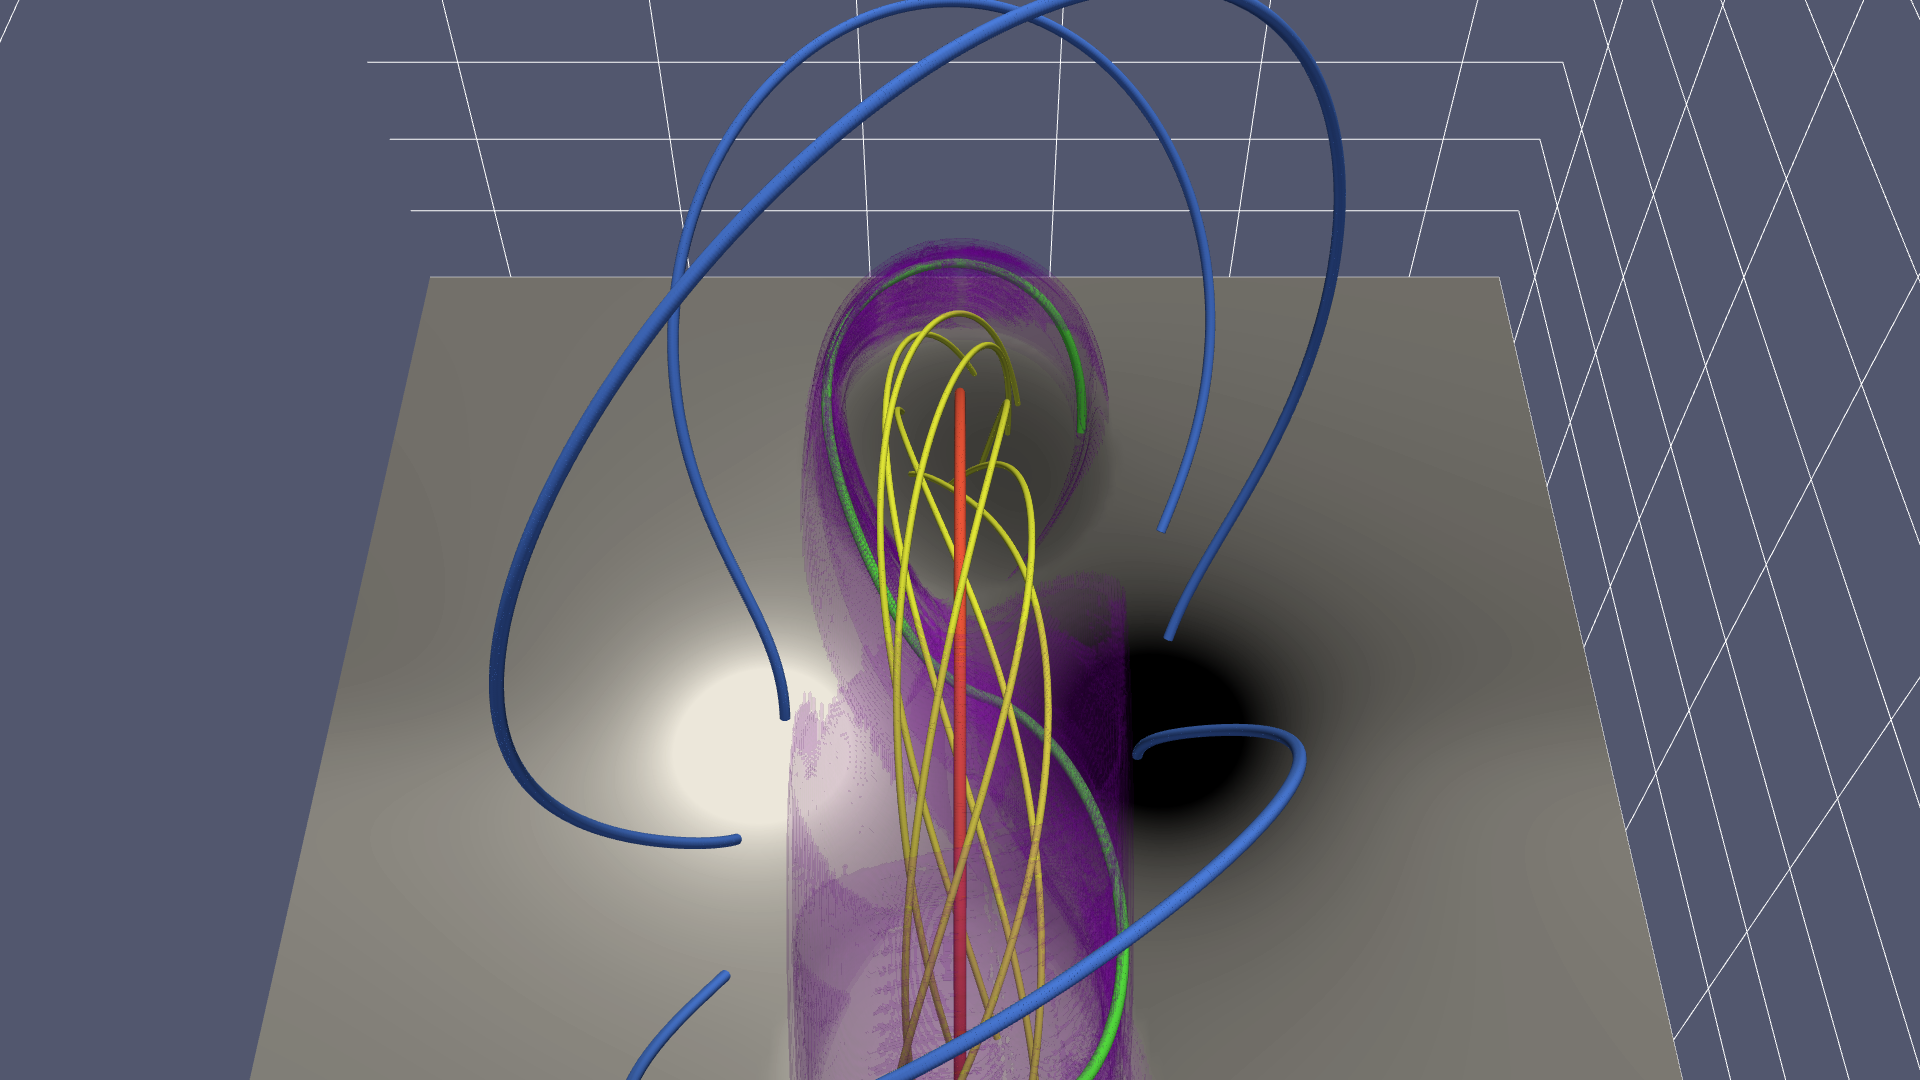

time: 7.95 s


In [27]:
#%%capture
idx_this =0

#for t_id in thetas:
if True:    
    
    #%% Visualization
    pv.set_plot_theme("ParaView")
    p = pv.Plotter(off_screen=False)
    p.add_mesh(surf,color='#9a04d9', smooth_shading=True, show_scalar_bar=False,opacity=0.07 )



    # center
    p0 = np.array([250,250,28.1742],dtype=np.float32)
    (lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
    points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
    line = pv.lines_from_points(points)
    tube = line.tube(radius=0.5)
    p.add_mesh(tube,smooth_shading=True,color="#ff5e41")

    # twist
    N_start=8
    r=6.5
    theta=np.linspace(0,2*np.pi,N_start)
    x_start = 250+np.cos(theta)*r
    z_start = np.sin(theta)*r
    for idx in range(N_start):
        pthis = np.array([x_start[idx],250,z_start[idx]+26.533]).astype(np.float32)
        (lx,ly,lz)=mt.TraceBline(Bx,By,Bz,pthis,dr=0.25,maxstep=1e4)
        points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
        line = pv.lines_from_points(points)
        tube = line.tube(radius=0.3)
        p.add_mesh(tube,smooth_shading=True,color="#f4ff41")



    # tube
    p0 = np.array([250,250,8.5],dtype=np.float32)
    (lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
    points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
    line = pv.lines_from_points(points)
    tube = line.tube(radius=0.5)
    p.add_mesh(tube,smooth_shading=True,color="#58FF41")    

    # cage
    p0 = np.array([250,250,80],dtype=np.float32)
    (lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
    points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
    line = pv.lines_from_points(points)
    tube = line.tube(radius=0.5)
    p.add_mesh(tube,smooth_shading=True,color="#5189ff")    


    p0 = np.array([250,200,45],dtype=np.float32)
    (lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
    points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
    line = pv.lines_from_points(points)
    tube = line.tube(radius=0.5)
    p.add_mesh(tube,smooth_shading=True,color="#5189ff")

    p0 = np.array([250,300,45],dtype=np.float32)
    (lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
    points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
    line = pv.lines_from_points(points)
    tube = line.tube(radius=0.5)
    p.add_mesh(tube,smooth_shading=True,color="#5189ff")



    xxi=np.arange(190,310)
    yyi=np.arange(190,310)
    xx2,yy2 = np.meshgrid(xxi,yyi,indexing='ij')
    zz2 = np.zeros_like(xx2)
    B0mesh = pv.StructuredGrid(xx2, yy2, zz2)
    p.add_mesh(B0mesh,scalars=Bz[xx2,yy2,0].T, cmap='gray',clim=[-2,2])


    #p.camera_position =[(-15.492773491535786, 73.03853292738464, 197.35581583546136),
    # (249.5, 250.00000762939453, 40.100989788770676),
    # (0.3980634584150215, 0.1995876143798703, 0.89538274903017)]

    theta=0*np.pi#t_id

    p.camera_position =[(250+100*np.sin(theta), 250+100*np.cos(theta), 160),
     (250, 250, 30),
     (0, 0, 1)]
    p.show_grid( xlabel='X', ylabel='Y', zlabel='Z',)
    p.show_axes()

    p.window_size = 1920, 1080
    #p.show()
    p.show(screenshot='movie/img'+str(idx_this).rjust(3,'0')+'.png',auto_close=False)
    #p.close()
    idx_this=idx_this+1

In [ ]:
idx_this.rjust('')

In [ ]:
[5]*8

In [28]:
import MagTool as mt
#collect blines
blines=[]

# center
p0 = np.array([250,250,28.1742],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
blines.append(points)

# twist
N_start=8
r=6.5
theta=np.linspace(0,2*np.pi,N_start)
x_start = 250+np.cos(theta)*r
z_start = np.sin(theta)*r
for idx in range(N_start):
    pthis = np.array([x_start[idx],250,z_start[idx]+28.1742]).astype(np.float32)
    (lx,ly,lz)=mt.TraceBline(Bx,By,Bz,pthis,dr=0.25,maxstep=1e4)
    points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
    blines.append(points)

# tube
p0 = np.array([250,250,8.5],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
blines.append(points)

# cage
p0 = np.array([250,250,80],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
blines.append(points)
    
p0 = np.array([250,200,45],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
blines.append(points)
    
p0 = np.array([250,300,45],dtype=np.float32)
(lx,ly,lz)=mt.TraceBline(Bx,By,Bz,p0,dr=0.25,maxstep=1e4)
points = np.stack((lx[~np.isnan(lx)],ly[~np.isnan(lx)],lz[~np.isnan(lx)]),1)
blines.append(points)


time: 2.03 s


In [29]:
np.savez('../QubeFinalGouziHFTv2.npz', Qube=Qube,Twube=Twube,
        xi=x_i_0,yi=y_i_0,zi=z_i_0,
        xfull=xfull,yfull=yfull,zfull=zfull,
        B0z=Bz[:,:,0],
        blines=blines)

time: 1.8 s


In [42]:
np.savez('../QubeFinalGouziHFT.npz', Qube=Qube,Twube=Twube,
        xi=x_i_0,yi=y_i_0,zi=z_i_0,
        xfull=xfull,yfull=yfull,zfull=zfull,
        B0z=Bz[:,:,0])

time: 2.63 s


In [1]:
import numpy as np
npzfile = np.load('../QubeFinal.npz',allow_pickle=True)
Qube = (npzfile['Qube'])
Twube = npzfile['Twube']
xi = npzfile['xi']
yi = npzfile['yi']
zi = npzfile['zi']
blines=npzfile['blines']


In [2]:
B0z = npzfile['B0z']

B0cube=B0z

divide by zero encountered in log10
divide by zero encountered in log10


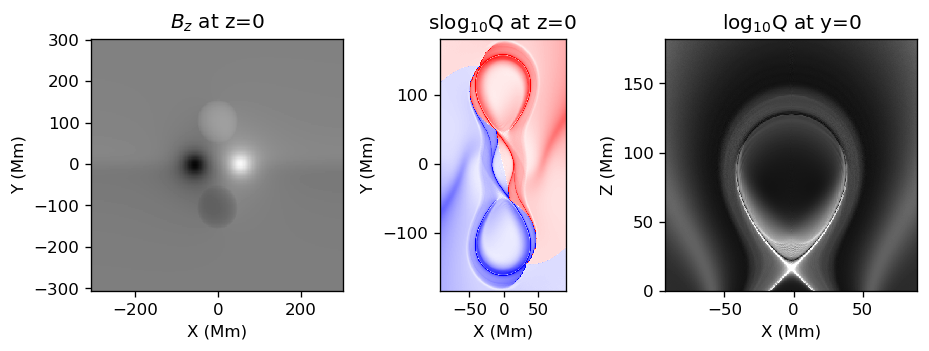

time: 1.06 s


In [70]:
import matplotlib.patches as patches
dpi=120

r_pix=3.04

fig=plt.figure(13,dpi=dpi,figsize=[7,7]);
ax0 = fig.add_axes([0.07,0.59,0.3,0.3])
img = ax0.imshow(Bz[:,:,0].T,cmap='gray',origin='lower', vmax=4,vmin=-4,
    extent=[-Bx.shape[0]/2*r_pix,Bx.shape[0]/2*r_pix,-Bx.shape[0]/2*r_pix,Bx.shape[0]/2*r_pix])
ax0.set_xlabel('X (Mm)')
ax0.set_ylabel('Y (Mm)')
ax0.set_xlim([(150-Bx.shape[0]/2)*r_pix,(350-Bx.shape[0]/2)*r_pix])
ax0.set_ylim([(150-Bx.shape[0]/2)*r_pix,(350-Bx.shape[0]/2)*r_pix])
ax0.set_title(r'$B_z$ at z=0')

ax1 = fig.add_axes([0.47,0.59,0.3*480/800,0.3])
img = ax1.imshow(np.log10(Qube[:,:,0].T)*np.sign(B0cube),cmap='bwr',origin='lower',
              vmax=4,vmin=-4,extent=[xi[0],xi[-1],yi[0],yi[-1]])
ax1.set_xlabel('X (Mm)')
ax1.set_ylabel('Y (Mm)')
ax1.set_title(r'$\rm slog_{10}$Q at z=0')


ax2 = fig.add_axes([0.74,0.59,0.3*480/440,0.3])
img = ax2.imshow(np.log10(Qube[:,int(Qube.shape[1]/2),:].T),cmap='gray',origin='lower',
              vmax=4,extent=[xi[0],xi[-1],zi[0],zi[0-1]])
ax2.set_xlabel('X (Mm)')
ax2.set_ylabel('Z (Mm)')
ax2.set_title(r'$\rm log_{10}$Q at y=0')


#rect = patches.Rectangle((x_range_real[0],y_range_real[0]),
#                         x_range_real[1]-x_range_real[0],y_range_real[1]-y_range_real[0],
#                         linewidth=1,edgecolor='k',facecolor='none')
#ax0.add_patch(rect)

fig.savefig('TD2D.pdf',bbox_inches='tight',pad_inches=0.1)

In [17]:
Qube[:,:,:].shape

(360, 720, 360)

time: 3 ms


In [23]:
B0cube.shape

(800, 480)

time: 0 ns


<ipython-input-31-8ad9e9de2214>:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(Qube[:,:,0].T)*np.sign(B0cube),cmap='bwr',


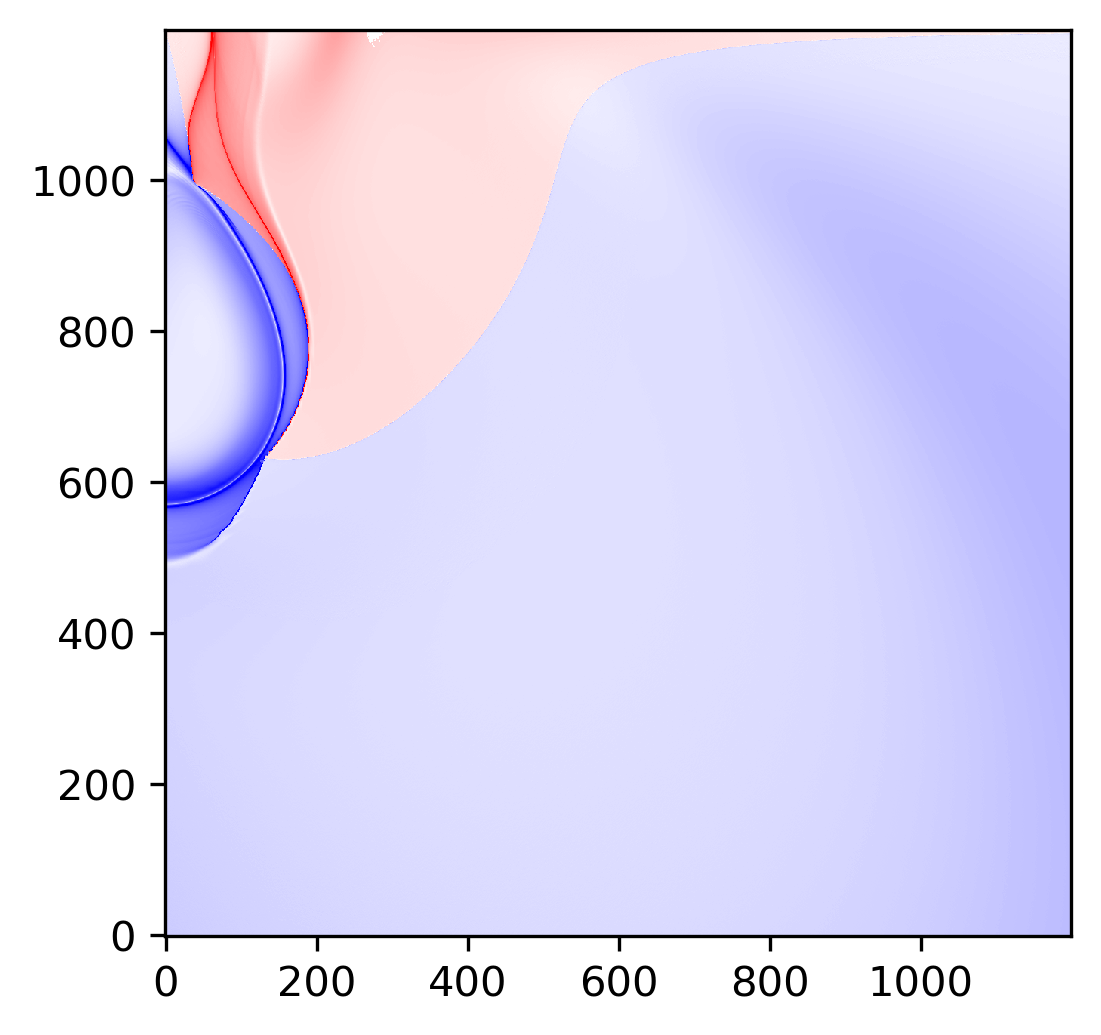

time: 613 ms


In [31]:
plt.figure(dpi=300)
plt.imshow(np.log10(Qube[:,:,0].T)*np.sign(B0cube),cmap='bwr',
           origin='lower',vmax=4,vmin=-4)